<a href="https://colab.research.google.com/github/TerradasExatas/Controle_Classico/blob/main/Controle_2_Projeto_no_EE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

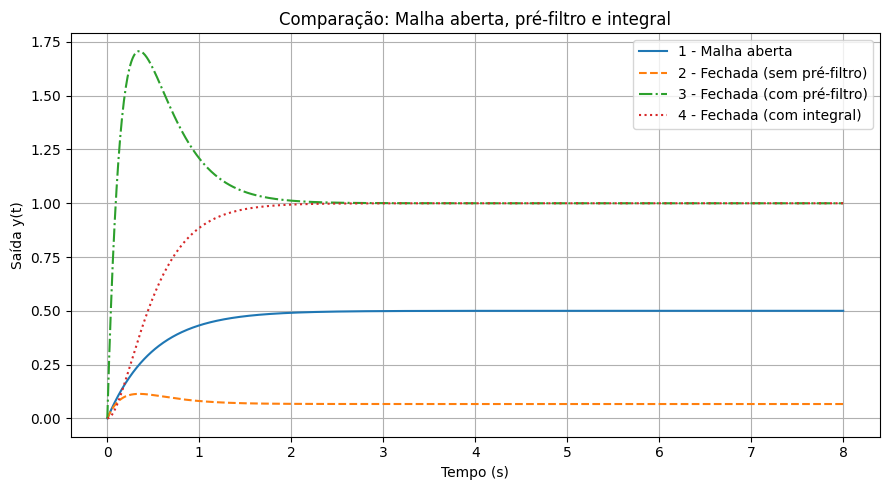

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import place_poles

# --- Sistema original: G(s) = (s+1)/(s^2+3s+2) ---
A = np.array([[0.0, 1.0],
              [-2.0, -3.0]])
B = np.array([[0.0],
              [1.0]])
C = np.array([[1.0, 1.0]])
D = np.array([[0.0]])

# --- Controlador de estados (casos 2 e 3) ---
# Polos desejados: -3 e -5
K = np.array([[13.0, 5.0]])
Acl = A - B @ K

# Pré-filtro N para rastreamento unitário
N = 1.0 / (C @ np.linalg.inv(-Acl) @ B)
B_r_pref = B * N
B_r_sem = B  # sem pré-filtro

# --- Sistema aumentado para controle integral (caso 4) ---
A_a = np.block([
    [A, np.zeros((2,1))],
    [-C, np.zeros((1,1))]
])
B_a = np.vstack((B, [[0.0]]))

# Escolha de polos desejados (um polo extra para integral)
desired_poles = np.array([-3, -5, -1])
res = place_poles(A_a, B_a, desired_poles)
K_a = res.gain_matrix

# Extrair ganhos como vetores 1D
K = K_a[0, :2].flatten()   # parte associada ao estado x
Ki = float(K_a[0, 2])      # parte associada ao integrador

# Matrizes de malha fechada (sistema aumentado)
A_cl_int = np.block([
    [A - B @ K.reshape(1,-1), -B * Ki],
    [-C, np.zeros((1,1))]
])
B_cl_int = np.vstack((np.zeros((2,1)), [[1.0]]))  # referência entra só no integrador
C_cl_int = np.hstack((C, np.zeros((1,1))))
D_cl_int = np.array([[0.0]])

# --- Definição dos sistemas ---
sys_open = signal.StateSpace(A, B, C, D)                    # 1) malha aberta
sys_closed_sem = signal.StateSpace(Acl, B_r_sem, C, D)      # 2) sem pré-filtro
sys_closed_pref = signal.StateSpace(Acl, B_r_pref, C, D)    # 3) com pré-filtro
sys_closed_int = signal.StateSpace(A_cl_int, B_cl_int, C_cl_int, D_cl_int)  # 4) integral

# --- Simulação das respostas ao degrau ---
t = np.linspace(0, 8, 801)
t1, y_open = signal.step(sys_open, T=t)
t2, y_closed_sem = signal.step(sys_closed_sem, T=t)
t3, y_closed_pref = signal.step(sys_closed_pref, T=t)
t4, y_closed_int = signal.step(sys_closed_int, T=t)

# --- Plot ---
plt.figure(figsize=(9,5))
plt.plot(t1, y_open, label='1 - Malha aberta')
plt.plot(t2, y_closed_sem, '--', label='2 - Fechada (sem pré-filtro)')
plt.plot(t3, y_closed_pref, '-.', label='3 - Fechada (com pré-filtro)')
plt.plot(t4, y_closed_int, ':', label='4 - Fechada (com integral)')
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('Saída y(t)')
plt.title('Comparação: Malha aberta, pré-filtro e integral')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from scipy.signal import place_poles, ss2tf

# --- Sistema em espaço de estados ---
# Função de transferência: G(s) = (s+1)/(s^2+3s+2)

A = np.array([[0.0, 1.0],
              [-2.0, -3.0]])
B = np.array([[0.0],
              [1.0]])
C = np.array([[1.0, 1.0]])
D = np.array([[0.0]])

# --- Sistema aumentado para controle integral ---
A_a = np.block([
    [A, np.zeros((2,1))],
    [-C, np.zeros((1,1))]
])
B_a = np.vstack((B, [[0.0]]))

# --- Polos desejados ---
desired_poles = np.array([-3.0, -5.0, -25.0])  # inclui polo em -1 para cancelar o zero

# --- Alocação de polos ---
res = place_poles(A_a, B_a, desired_poles)
K_a = res.gain_matrix.flatten()  # [k1, k2, Ki]

# Extrai ganhos individuais
k1, k2, Ki = K_a[0], K_a[1], K_a[2]

# --- Matrizes de malha fechada ---
A_cl = A_a - B_a @ K_a.reshape(1, -1)
B_cl = np.array([[0.0],[0.0],[1.0]])   # referência entra no integrador
C_cl = np.hstack((C, np.zeros((1,1))))
D_cl = np.array([[0.0]])

# --- Função de transferência de R(s) -> Y(s) ---
num, den = ss2tf(A_cl, B_cl, C_cl, D_cl)

# Ajusta num/den para eliminar ruídos numéricos
num = np.round(num.flatten(), 12)
den = np.round(den.flatten(), 12)

# Normaliza denominador para monico (coef. líder = 1)
if den[0] != 1.0:
    num = num / den[0]
    den = den / den[0]

# --- Resultados ---
print("Ganhos [k1, k2, Ki] =", K_a)
print("\nMatriz A_cl =\n", A_cl)
print("Matriz B_cl =\n", B_cl)
print("Matriz C_cl =\n", C_cl)
print("Matriz D_cl =\n", D_cl)

print("\nFunção de transferência T(s) = Num/Den")
print("Num =", num)
print("Den =", den)


Ganhos [k1, k2, Ki] = [-162.   30. -375.]

Matriz A_cl =
 [[  0.   1.   0.]
 [160. -33. 375.]
 [ -1.  -1.   0.]]
Matriz B_cl =
 [[0.]
 [0.]
 [1.]]
Matriz C_cl =
 [[1. 1. 0.]]
Matriz D_cl =
 [[0.]]

Função de transferência T(s) = Num/Den
Num = [  0.   0. 375. 375.]
Den = [  1.  33. 215. 375.]
